In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv

# import libraries:
import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np
import git
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
# import tension tools utilities:
from tensiometer import utilities


def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

2025-03-17 21:44:49.626514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 21:44:49.731922: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 21:44:49.733562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 21:44:51.511615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import cosmological data

In [2]:
# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
num_parameters = 2
num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})

param_names = ['Omega_m','H0'] #Shared paameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)

In [3]:
#Get the gaussian approximations
os.chdir(os.path.join(path_git))
from tensiometer import gaussian_tension
gaussian_A = gaussian_tension.gaussian_approximation(chain_A)
gaussian_B = gaussian_tension.gaussian_approximation(chain_B)
gaussian_C = gaussian_tension.gaussian_approximation(chain_C)
gaussian_D = gaussian_tension.gaussian_approximation(chain_D)

# Anova-like stimators

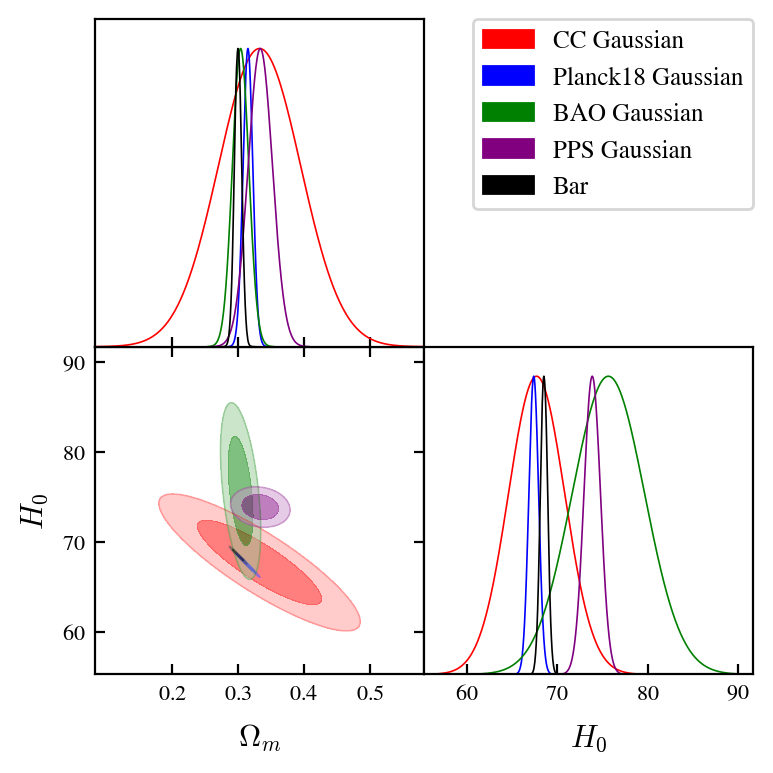

In [4]:
#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C + cov_D
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C, mean_D], [cov_A, cov_B, cov_C, cov_D])
mean_bar = centroid
cov_bar = centroid_covariance

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=param_names, labels=param_names, label='Bar')
colors = ['red', 'blue', 'green', 'purple', 'black']

g = plots.get_subplot_plotter()
g.triangle_plot([gaussian_A,gaussian_B,gaussian_C,gaussian_D, chain_bar], params=param_names,\
                legend_labels=['CC Gaussian','Planck18 Gaussian','BAO Gaussian','PPS Gaussian','Bar'],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
#g.export('figures_matrix_tension/contour_guassian.pdf')
plt.savefig('triangle_plot_data_centroid.pdf')

delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar
delta_theta_D = mean_D - mean_bar

## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [5]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 45.981057637521204
PTE: 2.396783708931806e-07
n_sigma: 5.16559
PTE: 2.7e-07
n_sigma: 5.14327


## Without dataset A

In [6]:
num_datasets = 3

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_B, mean_C, mean_D], [cov_B, cov_C, cov_D])
mean_bar = centroid
cov_bar = centroid_covariance
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar
delta_theta_D = mean_D - mean_bar


epsilon = np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 45.50409861526857
PTE: 3.715795773388165e-08
n_sigma: 5.50385
PTE: 4e-08
n_sigma: 5.49085


## Without dataset B

In [7]:
num_datasets = 3

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_C, mean_D], [cov_A, cov_C, cov_D])
mean_bar = centroid
cov_bar = centroid_covariance
delta_theta_A = mean_A - mean_bar
delta_theta_C = mean_C - mean_bar
delta_theta_D = mean_D - mean_bar


epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 8.631031094954757
PTE: 0.1954164621826317
n_sigma: 1.29472
PTE: 0.19544271
n_sigma: 1.29465


## Without dataset C

In [8]:
num_datasets = 3

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_D], [cov_A, cov_B, cov_D])
mean_bar = centroid
cov_bar = centroid_covariance
delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_D = mean_D - mean_bar


epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 40.22220737484812
PTE: 4.1193044435452917e-07
n_sigma: 5.06336
PTE: 4.8e-07
n_sigma: 5.03414


## Without dataset D

In [9]:
num_datasets = 3

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
mean_bar = centroid
cov_bar = centroid_covariance
delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar


epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))

print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 4.6745047191525
PTE: 0.586184887659609
n_sigma: 0.544373
PTE: 0.58614012
n_sigma: 0.544438
